In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [123]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [124]:
def learn_HAT_constant(c, case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None):
    np.random.seed(0)
    if cost_function == 'abs':
        cost = cost_abs
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    T[:,0] = c
    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        T[:,0] = c
#         print T
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T


In [125]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Learn H, A, T from Austin

In [178]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

### transfer learning with constant

In [157]:
c = 1
from scipy.optimize import nnls

pred_transfer_cons = {}
T_adapt_cons = {}
n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'

H_a, A_a_const, T_a = learn_HAT_constant(c, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

for random_seed in range(10):
    pred_transfer_cons[random_seed] = {}
    T_adapt_cons[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer_cons[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_cons[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT_constant(c, case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_const)

            T_adapt_cons[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a_const[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a_const, T_sd_adapt)

            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer_cons[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

In [158]:
T_1 = T_adapt_cons.copy()
pred_1 = pred_transfer_cons.copy()

In [137]:
for per in range(10, 110, 10):
    temp_01 = 0
    temp_1 = 0
    temp_10 = 0
    for random_seed in range(5):
        for rd in range(10):
            temp_01 += T_01[random_seed][per][rd]
            temp_1 += T_1[random_seed][per][rd]
            temp_10 += T_10[random_seed][per][rd]
    temp_01 = temp_01/50
    temp_1 = temp_1/50
    temp_10 = temp_10/50

In [138]:
temp = np.c_[temp_01, temp_1, temp_10]
df = pd.DataFrame(temp)
df = df.rename(columns={0:"factor0, c=0.1", 1:"factor1, c=0.1", 2:"factor2, c=0.1", 
                                3:"factor0, c=1", 4:"factor1, c=1", 5:"factor2, c=1", 
                                6:"factor0, c=10", 7:"factor1, c=10", 8:"factor2, c=10"})
df

,"factor0, c=0.1","factor1, c=0.1","factor2, c=0.1","factor0, c=1","factor1, c=1","factor2, c=1","factor0, c=10","factor1, c=10","factor2, c=10"
0,0.1,5.453397,0.000000,1.0,4.608581,0.000000,10.0,0.015551,0.019555
1,0.1,4.785499,0.000000,1.0,3.987874,0.000000,10.0,0.006601,0.007493
2,0.1,5.279679,0.000038,1.0,4.438395,0.000000,10.0,0.009673,0.011947
3,0.1,5.296967,0.295500,1.0,4.443146,0.295132,10.0,0.022764,0.038656
4,0.1,4.460212,2.201351,1.0,3.632600,2.182404,10.0,0.029017,2.991313
5,0.1,4.869397,1.459826,1.0,4.008033,1.456831,10.0,0.027566,1.844490
6,0.1,3.858099,3.751448,1.0,3.043814,3.719252,10.0,0.059284,5.433486
7,0.1,3.696568,4.347589,1.0,2.881505,4.308429,10.0,0.373920,6.364257
8,0.1,4.039364,4.645223,1.0,3.210204,4.598908,10.0,1.684946,6.467168
9,0.1,5.239067,1.736585,1.0,4.366759,1.721933,10.0,0.030271,2.661267


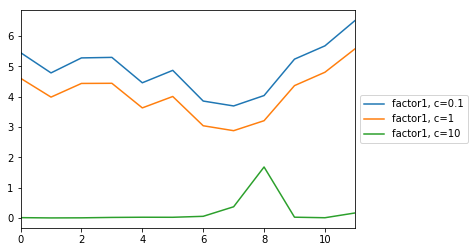

In [139]:
ax = df.iloc[:, [1, 4, 7]].plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# ax.legend(label={"factor1, c=0.1","factor1, c=0.1","factor1, c=0.1"})

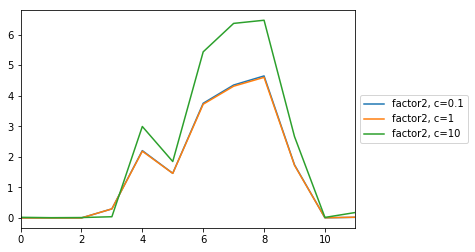

In [140]:
ax = df.iloc[:, [2, 5, 8]].plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [141]:
out_01 = {}
for random_seed in range(5):
    out_01[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_01[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_01[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_01[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_01[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [160]:
out_1 = {}
for random_seed in range(10):
    out_1[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_1[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_1[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_1[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_1[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [143]:
out_10 = {}
for random_seed in range(5):
    out_10[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_10[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_10[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_10[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_10[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [161]:
mean_10 = pd.Panel(out_10).mean(axis=0)
mean_1 = pd.Panel(out_1).mean(axis=0)
mean_01 = pd.Panel(out_01).mean(axis=0)

In [162]:
# df_out_normal = pd.DataFrame(out_normal)]
mean_10 = mean_10.rename(columns={'dw':'dw_10', 'fridge':'fridge_10', 'hvac':'hvac_10',
                                'mw':'mw_10', 'oven':"oven_10", 'wm':'wm_10'})
mean_1 = mean_1.rename(columns={'dw':'dw_1', 'fridge':'fridge_1', 'hvac':'hvac_1',
                                'mw':'mw_1', 'oven':"oven_1", 'wm':'wm_1'})
mean_01 = mean_01.rename(columns={'dw':'dw_01', 'fridge':'fridge_01', 'hvac':'hvac_01',
                                'mw':'mw_01', 'oven':"oven_01", 'wm':'wm_01'})

all_out = pd.concat([mean_10, mean_1, mean_01], axis=1)
all_out

,dw_10,fridge_10,hvac_10,mw_10,oven_10,wm_10,dw_1,fridge_1,hvac_1,mw_1,oven_1,wm_1,dw_01,fridge_01,hvac_01,mw_01,oven_01,wm_01
10,2.276265,10.801180,27.370706,2.047169,3.039032,0.728766,1.933465,10.084569,18.976466,1.821429,2.200185,0.768502,1.912141,11.195914,19.476330,2.287613,2.394933,0.925310
20,2.009101,9.455744,16.491924,2.113803,2.702775,0.695721,1.851426,10.394609,17.647749,1.923484,2.117366,0.835529,1.850155,10.949485,16.429806,2.246378,2.227736,0.905491
30,1.940545,9.217871,15.092344,2.143118,2.532631,0.723120,1.842565,10.409833,17.148064,1.940141,2.109246,0.846651,1.845956,11.088618,16.764664,2.249612,2.211172,0.928055
40,1.916315,9.100853,15.363143,2.158599,2.423890,0.743125,1.849312,10.294902,17.459191,1.978267,2.114105,0.836802,1.830045,10.874102,16.924905,2.243340,2.160352,0.915174
50,1.900508,9.087455,15.211666,2.166132,2.381569,0.751786,1.850495,10.076261,17.517720,1.988705,2.078681,0.823035,1.823724,10.587674,16.995545,2.238532,2.121196,0.901516
60,1.879542,9.026215,15.607736,2.180170,2.288006,0.768490,1.853583,9.961303,17.075692,1.999446,2.072502,0.815338,1.814157,10.225190,16.593159,2.233345,2.069816,0.887523
70,1.872087,9.014950,15.929091,2.185355,2.249761,0.776669,1.852030,9.903570,17.214264,2.008482,2.070292,0.812258,1.813869,10.087774,16.831258,2.228589,2.058070,0.880610
80,1.860816,9.060384,16.273923,2.192215,2.222744,0.786136,1.845495,9.947145,17.137578,2.020815,2.067998,0.817126,1.813278,10.116970,17.097854,2.229196,2.054005,0.882363
90,1.855698,9.043625,16.309448,2.197482,2.186251,0.793604,1.843523,9.946620,16.801343,2.029089,2.069425,0.819946,1.814678,10.044495,16.790647,2.228253,2.055647,0.878938
100,1.846442,9.128509,16.547886,2.206245,2.152120,0.805131,1.836571,9.979657,16.627025,2.040313,2.061515,0.826095,1.814125,10.059344,16.562766,2.229450,2.056747,0.879880


In [146]:
# df_out_normal = pd.DataFrame(out_normal)]
mean_10 = mean_10.rename(columns={'dw':'dw_10', 'fridge':'fridge_10', 'hvac':'hvac_10',
                                'mw':'mw_10', 'oven':"oven_10", 'wm':'wm_10'})
mean_1 = mean_1.rename(columns={'dw':'dw_1', 'fridge':'fridge_1', 'hvac':'hvac_1',
                                'mw':'mw_1', 'oven':"oven_1", 'wm':'wm_1'})
mean_01 = mean_01.rename(columns={'dw':'dw_01', 'fridge':'fridge_01', 'hvac':'hvac_01',
                                'mw':'mw_01', 'oven':"oven_01", 'wm':'wm_01'})

all_out = pd.concat([mean_10, mean_1, mean_01], axis=1)
all_out

,dw_10,fridge_10,hvac_10,mw_10,oven_10,wm_10,dw_1,fridge_1,hvac_1,mw_1,oven_1,wm_1,dw_01,fridge_01,hvac_01,mw_01,oven_01,wm_01
10,2.276265,10.801180,27.370706,2.047169,3.039032,0.728766,1.936080,10.042813,19.327428,1.815313,2.171315,0.752749,1.912141,11.195914,19.476330,2.287613,2.394933,0.925310
20,2.009101,9.455744,16.491924,2.113803,2.702775,0.695721,1.860039,10.507963,17.019375,1.923473,2.152007,0.852874,1.850155,10.949485,16.429806,2.246378,2.227736,0.905491
30,1.940545,9.217871,15.092344,2.143118,2.532631,0.723120,1.835533,10.525576,16.797420,1.930232,2.112408,0.852919,1.845956,11.088618,16.764664,2.249612,2.211172,0.928055
40,1.916315,9.100853,15.363143,2.158599,2.423890,0.743125,1.833373,10.521046,17.106728,1.978423,2.116448,0.851492,1.830045,10.874102,16.924905,2.243340,2.160352,0.915174
50,1.900508,9.087455,15.211666,2.166132,2.381569,0.751786,1.839193,10.266267,16.997989,1.987267,2.086139,0.836372,1.823724,10.587674,16.995545,2.238532,2.121196,0.901516
60,1.879542,9.026215,15.607736,2.180170,2.288006,0.768490,1.841976,10.004735,16.668180,2.001489,2.066052,0.819298,1.814157,10.225190,16.593159,2.233345,2.069816,0.887523
70,1.872087,9.014950,15.929091,2.185355,2.249761,0.776669,1.842970,9.980276,16.920901,2.012496,2.062228,0.820431,1.813869,10.087774,16.831258,2.228589,2.058070,0.880610
80,1.860816,9.060384,16.273923,2.192215,2.222744,0.786136,1.836694,10.029434,17.029101,2.023492,2.057460,0.825776,1.813278,10.116970,17.097854,2.229196,2.054005,0.882363
90,1.855698,9.043625,16.309448,2.197482,2.186251,0.793604,1.839929,9.962860,16.838986,2.030448,2.061804,0.822674,1.814678,10.044495,16.790647,2.228253,2.055647,0.878938
100,1.846442,9.128509,16.547886,2.206245,2.152120,0.805131,1.836571,9.979657,16.627025,2.040313,2.061515,0.826095,1.814125,10.059344,16.562766,2.229450,2.056747,0.879880


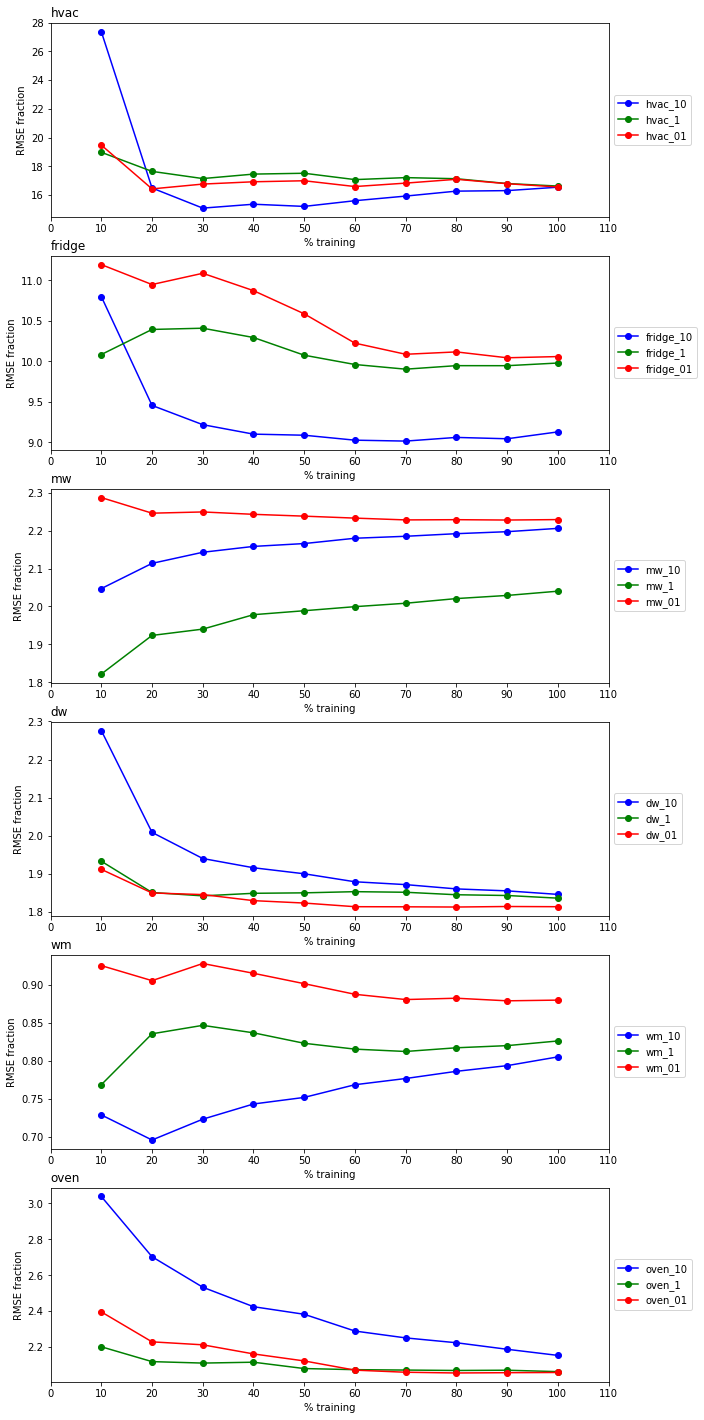

In [163]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_10']
    df2 = all_out[appliance+ '_1']
    df3 = all_out[appliance+ '_01']
#     df4 = all_out[appliance+ '_normal_const']
# df4 = all_out[appliance+ '_agg_2']
# df5 = all_out[appliance+ '_agg_3']
# df6 = all_out[appliance+ '_agg_4']
# df7 = all_out[appliance+ '_reg']
    df = pd.concat([df1, df2, df3], axis=1)
#     ax[count].plot(df)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
# plt.savefig("./analysis/transfer_const_new_1.png", bbox_inches="tight", dpi=300)

## -----------------------------------------------------------------------------------

In [216]:
for per in range(10, 20, 10):
    temp_01 = 0
    temp_1 = 0
    temp_10 = 0
    for random_seed in range(1):
        for rd in range(10):
            temp_01 = T_01[random_seed][per][rd]
            temp_1 = T_1[random_seed][per][rd]
            temp_10 = T_10[random_seed][per][rd]
    temp_01 = temp_01/10
    temp_1 = temp_1/10
    temp_10 = temp_10/10

In [226]:
temp = np.c_[temp_01, temp_1, temp_10]
df = pd.DataFrame(temp)
df

,0,1,2,3,4,5,6,7,8
0,0.01,0.232492,0.010487,0.1,0.227920,0.010788,1.0,0.166755,0.001644
1,0.01,0.237147,0.010676,0.1,0.232874,0.010968,1.0,0.173295,0.001064
2,0.01,0.230684,0.011957,0.1,0.225720,0.012321,1.0,0.161604,0.003066
3,0.01,0.315350,0.056041,0.1,0.312449,0.060276,1.0,0.013469,0.235029
4,0.01,0.187206,0.276977,0.1,0.187235,0.283021,1.0,0.096066,0.281089
5,0.01,0.387991,0.117339,0.1,0.387345,0.122743,1.0,0.289429,0.138787
6,0.01,0.108563,0.382206,0.1,0.109027,0.388927,1.0,0.037114,0.368520
7,0.01,0.126304,0.447902,0.1,0.127923,0.455417,1.0,0.095233,0.403670
8,0.01,0.096220,0.474688,0.1,0.097094,0.481661,1.0,0.041460,0.451773
9,0.01,0.249134,0.236892,0.1,0.245328,0.238898,1.0,0.159975,0.265017


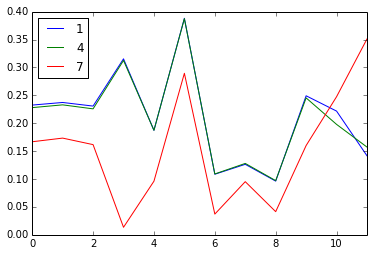

In [228]:
ax = df.iloc[:, [1, 4, 7]].plot()

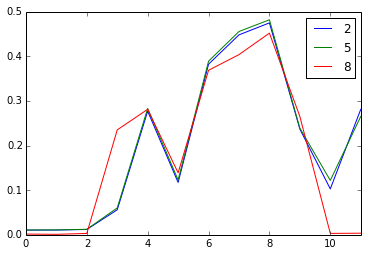

In [230]:
ax = df.iloc[:, [2, 5, 8]].plot()

### Tranfer learning with A_au

In [164]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

In [165]:
from scipy.optimize import nnls

pred_transfer = {}
T_adapt_transfer = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
    T_adapt_transfer[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_transfer[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
            T_adapt_transfer[random_seed][adapt_percentage][rd] = T_sd_adapt

            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
            

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

### Normal learning

In [156]:
pred = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'

for random_seed in range(10):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

### Normal learning with constant

In [ ]:
pred_normal_const = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'
c = 1

for random_seed in range(10):
    pred_normal_const[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_normal_const[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT_constant(c, case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal_const[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

In [ ]:
out_transfer_cons = {}
for random_seed in range(5):
    out_transfer_cons[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_cons[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_cons[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_cons[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_cons[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [ ]:
out_transfer = {}
for random_seed in range(5):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [ ]:
out = {}
for random_seed in range(5):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [ ]:
out_normal_cons = {}
for random_seed in range(5):
    out_normal_cons[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal_cons[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_normal_const[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal_cons[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal_cons[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [ ]:
mean_out_transfer_const_10 = pd.Panel(out_transfer_cons).mean(axis=0)
mean_out_normal_const_10 = pd.Panel(out_normal_cons).mean(axis=0)
std_out_normal_const_10 = pd.Panel(out_normal_cons).std(axis=0).values
std_out_transfer_const_10 = pd.Panel(out_transfer_cons).std(axis=0).values
sum_out_transfer_const_10 = mean_out_transfer_const_10.sum(axis=1)
sum_out_normal_const_10 = mean_out_normal_const_10.sum(axis=1)

In [ ]:
mean_out_transfer_const_01 = pd.Panel(out_transfer_cons).mean(axis=0)
mean_out_normal_const_01 = pd.Panel(out_normal_cons).mean(axis=0)
std_out_normal_const_01 = pd.Panel(out_normal_cons).std(axis=0).values
std_out_transfer_const_01 = pd.Panel(out_transfer_cons).std(axis=0).values
sum_out_transfer_const_01 = mean_out_transfer_const_01.sum(axis=1)
sum_out_normal_const_01 = mean_out_normal_const_01.sum(axis=1)

In [ ]:
mean_out_transfer_const_1 = pd.Panel(out_transfer_cons).mean(axis=0)
mean_out_normal_const_1 = pd.Panel(out_normal_cons).mean(axis=0)
std_out_normal_const_1 = pd.Panel(out_normal_cons).std(axis=0).values
std_out_transfer_const_1 = pd.Panel(out_transfer_cons).std(axis=0).values
sum_out_transfer_const_1 = mean_out_transfer_const_1.sum(axis=1)
sum_out_normal_const_1 = mean_out_normal_const_1.sum(axis=1)

In [165]:
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)
mean_out_normal = pd.Panel(out).mean(axis=0)

In [166]:
std_out_normal = pd.Panel(out).std(axis=0).values
std_out_transfer = pd.Panel(out_transfer).std(axis=0).values

In [167]:
sum_out_transfer = mean_out_transfer.sum(axis=1)
sum_out_normal = mean_out_normal.sum(axis=1)

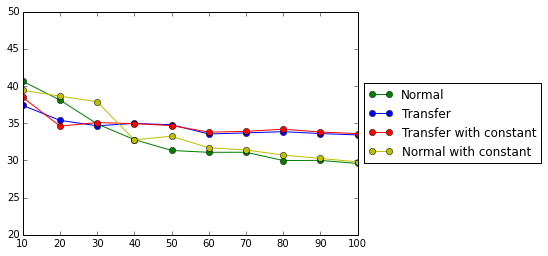

In [196]:
# df_out_normal = pd.DataFrame(out_normal)]
df_sum_out_normal = pd.DataFrame(sum_out_normal, columns={"Normal"})
df_sum_out_normal_const_01 = pd.DataFrame(sum_out_normal_const_01, columns={"Normal with constant"})
df_sum_out_transfer = pd.DataFrame(sum_out_transfer, columns={"Transfer"})
df_sum_out_transfer_const_01 = pd.DataFrame(sum_out_transfer_const_01, columns={"Transfer with constant"})



all_out = pd.concat([df_sum_out_normal,df_sum_out_transfer], axis=1)
all_out = pd.concat([all_out, df_sum_out_transfer_const_01], axis=1)
all_out = pd.concat([all_out, df_sum_out_normal_const_01], axis=1)

all_out.plot(ylim=(20, 50), marker='o', color=['g', 'b','r', 'y', 'k', 'c'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# pd.DataFrame(all_out).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])



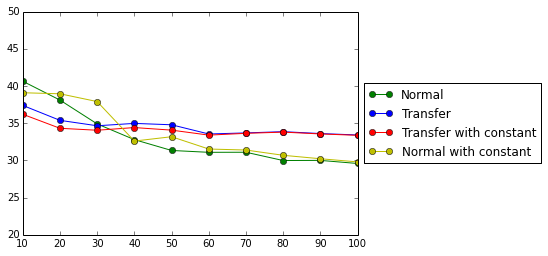

In [197]:
# df_out_normal = pd.DataFrame(out_normal)]
df_sum_out_normal = pd.DataFrame(sum_out_normal, columns={"Normal"})
df_sum_out_normal_const_1 = pd.DataFrame(sum_out_normal_const_1, columns={"Normal with constant"})
df_sum_out_transfer = pd.DataFrame(sum_out_transfer, columns={"Transfer"})
df_sum_out_transfer_const_1 = pd.DataFrame(sum_out_transfer_const_1, columns={"Transfer with constant"})



all_out = pd.concat([df_sum_out_normal,df_sum_out_transfer], axis=1)
all_out = pd.concat([all_out, df_sum_out_transfer_const_1], axis=1)
all_out = pd.concat([all_out, df_sum_out_normal_const_1], axis=1)

all_out.plot(ylim=(20, 50), marker='o', color=['g', 'b','r', 'y', 'k', 'c'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# pd.DataFrame(all_out).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])



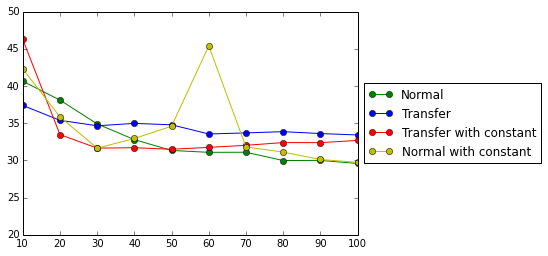

In [195]:
# df_out_normal = pd.DataFrame(out_normal)]
df_sum_out_normal = pd.DataFrame(sum_out_normal, columns={"Normal"})
df_sum_out_normal_const_10 = pd.DataFrame(sum_out_normal_const_10, columns={"Normal with constant"})
df_sum_out_transfer = pd.DataFrame(sum_out_transfer, columns={"Transfer"})
df_sum_out_transfer_const_10 = pd.DataFrame(sum_out_transfer_const_10, columns={"Transfer with constant"})



all_out = pd.concat([df_sum_out_normal,df_sum_out_transfer], axis=1)
all_out = pd.concat([all_out, df_sum_out_transfer_const_10], axis=1)
all_out = pd.concat([all_out, df_sum_out_normal_const_10], axis=1)

all_out.plot(ylim=(20, 50), marker='o', color=['g', 'b','r', 'y', 'k', 'c'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# pd.DataFrame(all_out).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])




KeyError: 'hvac_transfer'

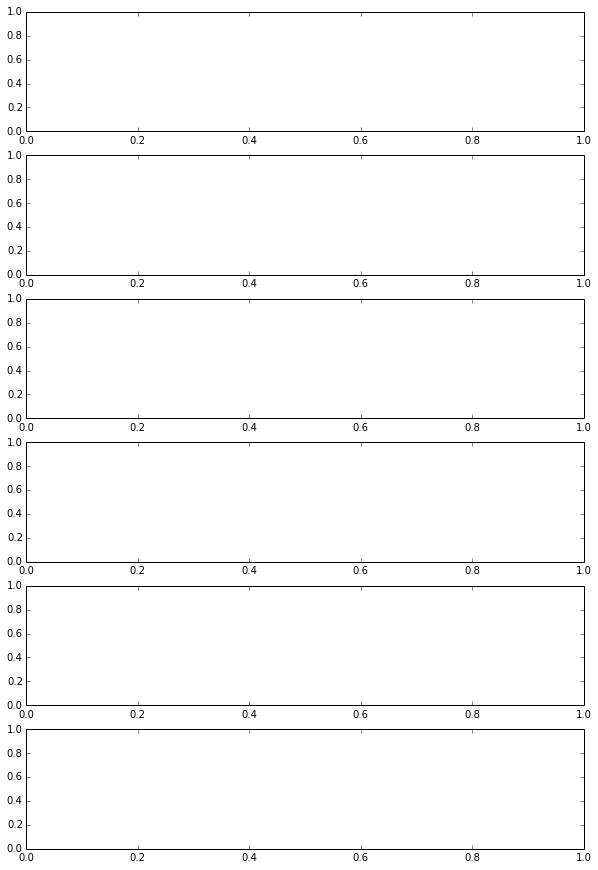

In [134]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_transfer']
    df2 = all_out[appliance+ '_normal']
    df3 = all_out[appliance+ '_transfer_const']
    df4 = all_out[appliance+ '_normal_const']
# df4 = all_out[appliance+ '_agg_2']
# df5 = all_out[appliance+ '_agg_3']
# df6 = all_out[appliance+ '_agg_4']
# df7 = all_out[appliance+ '_reg']
    df = pd.concat([df1, df2, df3, df4], axis=1)
#     ax[count].plot(df)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/transfer_const_new_1.png", bbox_inches="tight", dpi=300)

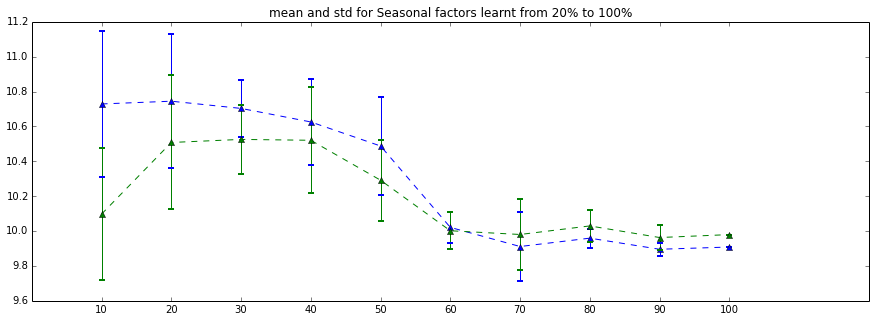

In [123]:
index = np.arange(10, 110, 10)
plt.figure(figsize=(15, 5))
idx = 1
# plt.errorbar(index, mean_out_normal[:,idx], yerr = std_out_normal[:, idx],  linestyle='--', fmt='^', capthick=2)
# plt.errorbar(index, mean_out_normal_const[:,idx], yerr = std_out_normal_const[:, idx],  linestyle='--', fmt='^', capthick=2)
plt.errorbar(index, mean_out_transfer[:,idx], yerr = std_out_transfer[:, idx],  linestyle='--', fmt='^', capthick=2)
plt.errorbar(index, mean_out_transfer_const[:,idx], yerr = std_out_transfer_const[:, idx],  linestyle='--', fmt='^', capthick=2)



plt.xticks(index)
plt.title("mean and std for Seasonal factors learnt from 20% to 100%")

In [81]:
mean_out_transfer

,dw,fridge,hvac,mw,oven,wm
10,1.896149,10.728884,19.165244,2.275938,2.368300,0.956603
20,1.845003,10.744633,17.360707,2.228282,2.258578,0.945991
30,1.837553,10.703311,16.737641,2.211619,2.225029,0.939799
40,1.822103,10.625665,17.181808,2.218375,2.197245,0.928837
50,1.819624,10.487651,17.173355,2.213250,2.175712,0.918199
60,1.808957,10.020999,16.499423,2.214518,2.106902,0.900235
70,1.809677,9.911326,16.771457,2.210997,2.095693,0.895698
80,1.806664,9.959254,16.901571,2.210339,2.087744,0.896844
90,1.806392,9.895565,16.715289,2.208609,2.088767,0.893647
100,1.806072,9.908399,16.510238,2.210948,2.089518,0.892767


In [82]:
# df_out_normal = pd.DataFrame(out_normal)]
mean_out_normal = mean_out_normal.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})
mean_out_normal_const = mean_out_normal_const.rename(columns={'dw':'dw_normal_const', 'fridge':'fridge_normal_const', 'hvac':'hvac_normal_const',
                                             'mw':'mw_normal_const', 'oven':"oven_normal_const", 'wm':'wm_normal_const'})
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
mean_out_transfer_const = mean_out_transfer_const.rename(columns={'dw':'dw_transfer_const', 'fridge':'fridge_transfer_const', 'hvac':'hvac_transfer_const',
                                             'mw':'mw_transfer_const', 'oven':"oven_transfer_const", 'wm':'wm_transfer_const'})

all_out = pd.concat([mean_out_normal, mean_out_transfer], axis=1)
all_out = pd.concat([all_out, mean_out_transfer_const], axis=1)
all_out = pd.concat([all_out, mean_out_normal_const], axis=1)



In [83]:
all_out

,dw_normal,fridge_normal,hvac_normal,mw_normal,oven_normal,wm_normal,dw_transfer,fridge_transfer,hvac_transfer,mw_transfer,...,hvac_transfer_const,mw_transfer_const,oven_transfer_const,wm_transfer_const,dw_normal_const,fridge_normal_const,hvac_normal_const,mw_normal_const,oven_normal_const,wm_normal_const
10,2.194967,9.836595,19.939889,2.229066,2.933905,3.505221,1.896149,10.728884,19.165244,2.275938,...,19.413071,1.819702,2.178880,0.764959,2.266048,9.404893,19.876820,2.128006,2.577961,2.841165
20,2.072986,8.909497,20.085306,2.252912,2.809232,1.977449,1.845003,10.744633,17.360707,2.228282,...,17.019375,1.923473,2.152007,0.852874,2.114519,9.302055,20.832518,2.233298,2.777244,1.693874
30,2.065477,7.698897,19.346374,2.000235,2.631065,1.160443,1.837553,10.703311,16.737641,2.211619,...,16.797420,1.930232,2.112408,0.852919,2.080384,7.770273,22.520970,1.992945,2.431539,1.110564
40,2.014322,7.436626,18.162829,1.955053,2.366252,0.856967,1.822103,10.625665,17.181808,2.218375,...,17.111093,1.979140,2.114502,0.853472,2.037500,7.350921,18.154562,1.924905,2.259526,0.871868
50,1.988308,7.201017,17.312697,1.855603,2.188801,0.790453,1.819624,10.487651,17.173355,2.213250,...,17.015275,1.987438,2.098857,0.834192,1.994361,7.428477,18.874736,1.852686,2.200651,0.831451
60,1.943226,7.290879,17.188372,1.764170,2.177912,0.721489,1.808957,10.020999,16.499423,2.214518,...,16.668794,2.001335,2.066099,0.818834,1.952508,7.387830,17.581439,1.791340,2.103105,0.712755
70,1.906359,7.161650,17.350588,1.770781,2.187945,0.718699,1.809677,9.911326,16.771457,2.210997,...,16.920947,2.012497,2.062230,0.820432,1.917207,7.227055,17.652315,1.777994,2.108697,0.710755
80,1.897110,6.914165,16.529113,1.771104,2.144405,0.727057,1.806664,9.959254,16.901571,2.210339,...,17.029101,2.023492,2.057460,0.825776,1.910105,7.010215,17.161795,1.771544,2.118649,0.714461
90,1.885820,7.068492,16.436823,1.754614,2.157057,0.698107,1.806392,9.895565,16.715289,2.208609,...,16.838986,2.030448,2.061804,0.822674,1.896717,7.104501,16.702227,1.771018,2.069380,0.679047
100,1.884434,6.988978,16.162964,1.742488,2.121319,0.684762,1.806072,9.908399,16.510238,2.210948,...,16.627025,2.040313,2.061515,0.826095,1.882310,7.036109,16.349865,1.744120,2.120033,0.664342


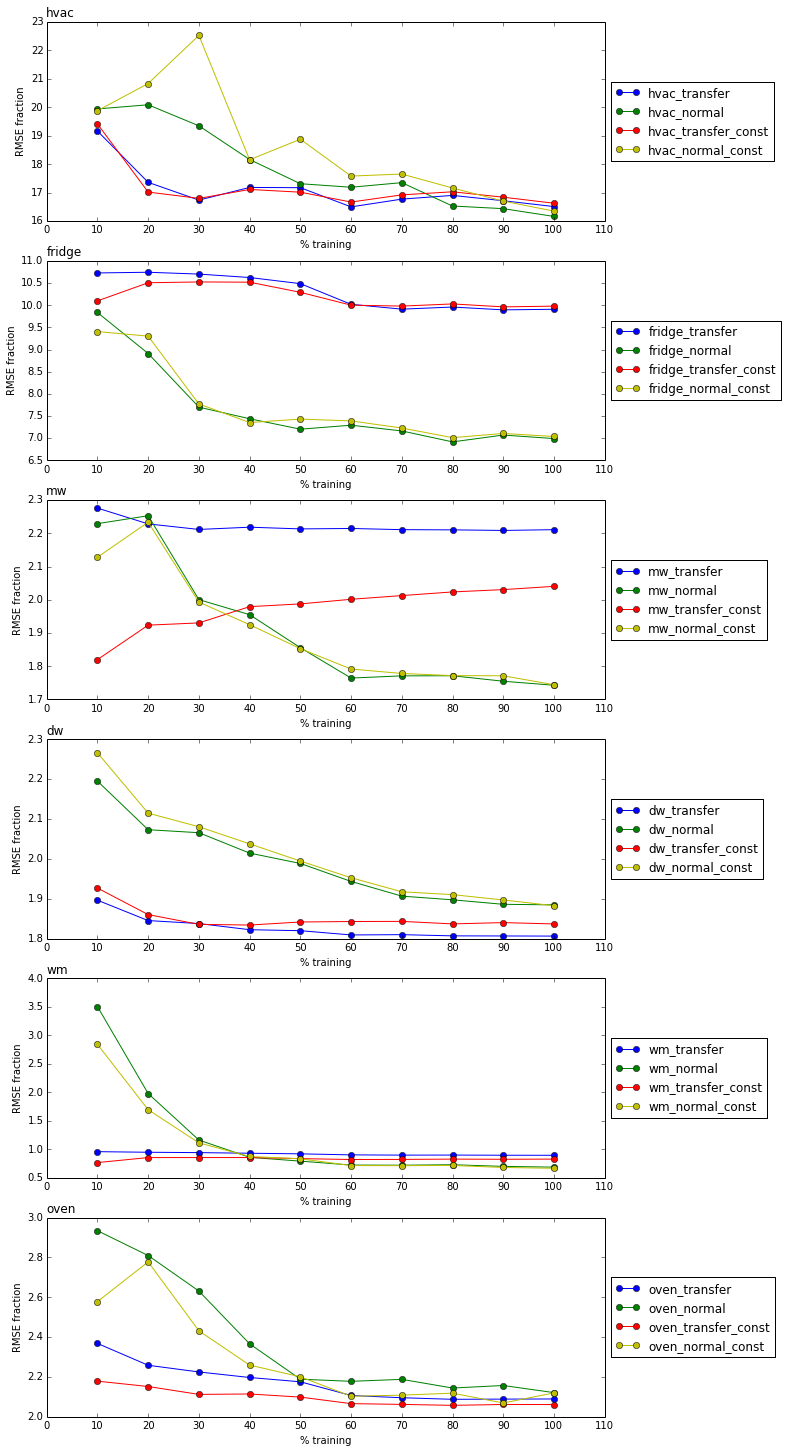

In [84]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_transfer']
    df2 = all_out[appliance+ '_normal']
    df3 = all_out[appliance+ '_transfer_const']
    df4 = all_out[appliance+ '_normal_const']
# df4 = all_out[appliance+ '_agg_2']
# df5 = all_out[appliance+ '_agg_3']
# df6 = all_out[appliance+ '_agg_4']
# df7 = all_out[appliance+ '_reg']
    df = pd.concat([df1, df2, df3, df4], axis=1)
#     ax[count].plot(df)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/transfer_const_new_1.png", bbox_inches="tight", dpi=300)